---
## 📦 CELL 1: Install Dependencies

In [1]:
# !pip install -q spacy
# !python -m spacy download en_core_web_sm
# !pip install -q spacy-transformers  # Optional: for better accuracte

# 1) upgrade pip, force-reinstall a numpy <2 build and matching deps
!pip install -q --upgrade pip

!pip install numpy<2.0

# 2) force-reinstall compatible numeric/wheel packages (will rebuild/install wheels)
#!pip install -q --force-reinstall "numpy<2" "scipy<1.11" "srsly<3.0.0" "spacy==3.7.2" "matplotlib" "spacy-transformers"
!pip install spacy==3.8.0 numpy<2.0 matplotlib==3.7.2 scikit-learn==1.2.2

# 3) download the language model
!python -m spacy download en_core_web_sm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.7 MB/s eta 0:00:00
/bin/bash: line 1: 2.0: No such file or directory
/bin/bash: line 1: 2.0: No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.4 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


---
## 📥 CELL 2: Import Libraries

In [2]:
import json
import random
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


---
## 📂 CELL 3: Load & Prepare Data

**⚠️ IMPORTANT: Update the path below to your uploaded dataset!**

In [3]:
def load_training_data(json_path):
    """
    Load LLM-generated training data
    
    Expected JSON format:
    {
      "examples": [
        {
          "text": "ngl this is bussin fr",
          "entities": [
            {"text": "ngl", "start": 0, "end": 3, "label": "SLANG"},
            {"text": "bussin", "start": 13, "end": 19, "label": "SLANG"},
            {"text": "fr", "start": 20, "end": 22, "label": "SLANG"}
          ]
        }
      ]
    }
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Convert to spaCy format: [(text, {"entities": [(start, end, label)]})]
    spacy_format = []
    
    for example in data['examples']:
        text = example['text']
        entities = [
            (ent['start'], ent['end'], ent['label']) 
            for ent in example['entities']
        ]
        spacy_format.append((text, {"entities": entities}))
    
    return spacy_format

# ⚠️ UPDATE THIS PATH TO YOUR DATASET!
# Example: '/kaggle/input/your-dataset-name/slang_training_data.json'
TRAIN_DATA = load_training_data('/kaggle/input/updated-genz-slang-dataset/slang_training_data.json')

print(f"📊 Loaded {len(TRAIN_DATA)} training examples")
print(f"\n📝 Sample example:")
print(f"Text: {TRAIN_DATA[0][0]}")
print(f"Entities: {TRAIN_DATA[0][1]['entities']}")

📊 Loaded 2188 training examples

📝 Sample example:
Text: ngl this new album is bussin fr fr no cap 🔥
Entities: [(0, 3, 'SLANG'), (22, 28, 'SLANG'), (29, 34, 'SLANG'), (35, 41, 'SLANG')]


---
## 🔀 CELL 4: Train/Validation Split

In [4]:
# Split 80% train, 20% validation
train_data, val_data = train_test_split(
    TRAIN_DATA, 
    test_size=0.2, 
    random_state=42
)

print(f"📊 Data Split:")
print(f"  Training: {len(train_data)} examples")
print(f"  Validation: {len(val_data)} examples")

📊 Data Split:
  Training: 1750 examples
  Validation: 438 examples


---
## 🏗️ CELL 5: Create Blank spaCy Model

In [5]:
def create_model(use_transformer=False):
    """
    Create a blank spaCy model with NER pipeline
    
    Args:
        use_transformer: If True, use transformer-based model (slower, more accurate)
                        If False, use standard model (faster, good enough)
    """
    if use_transformer:
        # More accurate but slower
        print("🤖 Creating transformer-based model...")
        nlp = spacy.blank("en")
        config = {
            "model": {
                "@architectures": "spacy-transformers.TransformerModel.v3",
                "name": "roberta-base",
                "tokenizer_config": {"use_fast": True}
            }
        }
        nlp.add_pipe("transformer", config=config)
        nlp.add_pipe("ner")
    else:
        # Faster and sufficient for most cases
        print("⚡ Creating standard model...")
        nlp = spacy.blank("en")
        nlp.add_pipe("ner")
    
    # Add SLANG label to NER
    ner = nlp.get_pipe("ner")
    ner.add_label("SLANG")
    
    print(f"✅ Model created with labels: {ner.labels}")
    return nlp

# Create model (set use_transformer=True for better accuracy)
nlp = create_model(use_transformer=False)

⚡ Creating standard model...
✅ Model created with labels: ('SLANG',)


---
## 🎓 CELL 6: Training Function

In [6]:
def train_ner_model(nlp, train_data, val_data, n_iter=30):
    """
    Train the NER model
    
    Args:
        nlp: spaCy model
        train_data: Training examples
        val_data: Validation examples
        n_iter: Number of training iterations
    
    Returns:
        Trained model and training history
    """
    
    print(f"\n🚀 Starting training for {n_iter} iterations...\n")
    
    # Get NER pipeline
    ner = nlp.get_pipe("ner")
    
    # Disable other pipelines during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    with nlp.disable_pipes(*other_pipes):
        # Initialize the model
        optimizer = nlp.initialize(lambda: train_examples(nlp, train_data))
        
        # Training loop
        for iteration in range(n_iter):
            random.shuffle(train_data)
            losses = {}
            
            # Batch training
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            
            for batch in batches:
                examples = train_examples(nlp, batch)
                nlp.update(
                    examples,
                    drop=0.35,  # Dropout for regularization
                    losses=losses,
                    sgd=optimizer
                )
            
            # Validation loss
            val_losses = {}
            val_examples = train_examples(nlp, val_data)
            for example in val_examples:
                nlp.update([example], drop=0.0, losses=val_losses, sgd=optimizer)
            
            # Record history
            train_loss = losses.get('ner', 0)
            val_loss = val_losses.get('ner', 0)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            
            # Print progress
            if (iteration + 1) % 5 == 0:
                print(f"Iteration {iteration + 1}/{n_iter}")
                print(f"  Train Loss: {train_loss:.4f}")
                print(f"  Val Loss: {val_loss:.4f}")
                print()
    
    print("✅ Training complete!")
    return nlp, history

def train_examples(nlp, data):
    """Convert training data to Example objects"""
    examples = []
    for text, annotations in data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        examples.append(example)
    return examples

# Train the model
nlp, history = train_ner_model(
    nlp, 
    train_data, 
    val_data, 
    n_iter=30  # Adjust based on your data size
)


🚀 Starting training for 30 iterations...

Iteration 5/30
  Train Loss: 491.3461
  Val Loss: 67.5563

Iteration 10/30
  Train Loss: 354.7007
  Val Loss: 26.2387

Iteration 15/30
  Train Loss: 214.4472
  Val Loss: 21.7594

Iteration 20/30
  Train Loss: 177.4700
  Val Loss: 8.5622

Iteration 25/30
  Train Loss: 139.4051
  Val Loss: 7.5491

Iteration 30/30
  Train Loss: 117.6142
  Val Loss: 14.1288

✅ Training complete!


---
## 📈 CELL 7: Plot Training History

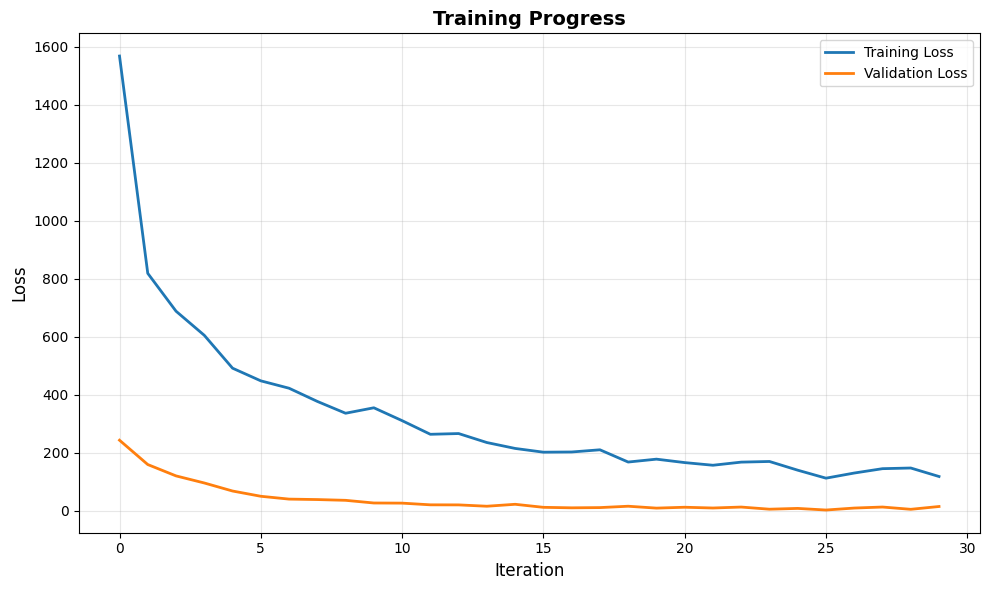

📊 Training plot saved as 'training_history.png'


In [7]:
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Progress', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

print("📊 Training plot saved as 'training_history.png'")

---
## 🎯 CELL 8: Evaluation Function

In [8]:
def evaluate_model(nlp, test_data):
    """
    Evaluate model performance
    
    Returns:
        Dictionary with precision, recall, F1 score
    """
    print("\n📊 Evaluating model...\n")
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for text, annotations in test_data:
        # Get predictions
        doc = nlp(text)
        predicted = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        
        # Get ground truth
        true = [(start, end, label) for start, end, label in annotations['entities']]
        
        # Calculate metrics
        for pred in predicted:
            if pred in true:
                true_positives += 1
            else:
                false_positives += 1
        
        for truth in true:
            if truth not in predicted:
                false_negatives += 1
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }
    
    print("📈 Evaluation Results:")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1 Score: {f1:.4f} ({f1*100:.2f}%)")
    print(f"\n  True Positives: {true_positives}")
    print(f"  False Positives: {false_positives}")
    print(f"  False Negatives: {false_negatives}")
    
    return metrics

# Evaluate on validation set
metrics = evaluate_model(nlp, val_data)


📊 Evaluating model...

📈 Evaluation Results:
  Precision: 0.9606 (96.06%)
  Recall: 0.8941 (89.41%)
  F1 Score: 0.9262 (92.62%)

  True Positives: 439
  False Positives: 18
  False Negatives: 52


---
## 🧪 CELL 9: Test on Examples

In [9]:
test_sentences = [
    "ngl this movie is bussin fr fr no cap",
    "lowkey that outfit is mid but the vibes are immaculate",
    "she ate and left no crumbs periodt",
    "this song hits different at 3am deadass",
    "my dog is living rent free in my head rn",
    "bet this is gonna slay on TikTok fr",
    "finna watch this show it looks fire",
    "that's cap bro you didn't really do that"
]

print("\n🧪 Testing on sample sentences:\n")
for text in test_sentences:
    doc = nlp(text)
    print(f"📝 Text: {text}")
    if doc.ents:
        print("   Detected slang:")
        for ent in doc.ents:
            print(f"     • '{ent.text}' at position {ent.start_char}-{ent.end_char}")
    else:
        print("   No slang detected")
    print()


🧪 Testing on sample sentences:

📝 Text: ngl this movie is bussin fr fr no cap
   Detected slang:
     • 'ngl' at position 0-3
     • 'bussin' at position 18-24
     • 'fr fr' at position 25-30
     • 'no cap' at position 31-37

📝 Text: lowkey that outfit is mid but the vibes are immaculate
   Detected slang:
     • 'lowkey' at position 0-6
     • 'mid' at position 22-25

📝 Text: she ate and left no crumbs periodt
   Detected slang:
     • 'ate and left no crumbs' at position 4-26
     • 'periodt' at position 27-34

📝 Text: this song hits different at 3am deadass
   Detected slang:
     • 'hits different' at position 10-24

📝 Text: my dog is living rent free in my head rn
   Detected slang:
     • 'living rent free' at position 10-26
     • 'rn' at position 38-40

📝 Text: bet this is gonna slay on TikTok fr
   Detected slang:
     • 'bet' at position 0-3
     • 'slay' at position 18-22
     • 'fr' at position 33-35

📝 Text: finna watch this show it looks fire
   Detected slang:
     • 

---
## 💾 CELL 10: Save Model

In [10]:
output_dir = Path("/kaggle/working/slang_ner_model")
nlp.to_disk(output_dir)

print(f"✅ Model saved to: {output_dir}")
print(f"\n📦 To use this model later:")
print(f"   import spacy")
print(f"   nlp = spacy.load('{output_dir}')")

# Save metrics
with open(output_dir / "metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metrics saved to: {output_dir}/metrics.json")

✅ Model saved to: /kaggle/working/slang_ner_model

📦 To use this model later:
   import spacy
   nlp = spacy.load('/kaggle/working/slang_ner_model')
✅ Metrics saved to: /kaggle/working/slang_ner_model/metrics.json


---
## 📤 CELL 11: Create Production Class (Optional)

In [11]:
production_code = '''
import spacy
from typing import List, Dict

class SlangDetector:
    """Production-ready slang detection class"""
    
    def __init__(self, model_path: str):
        """Load trained slang NER model"""
        self.nlp = spacy.load(model_path)
    
    def detect(self, text: str) -> List[Dict]:
        """
        Detect all slang terms in text
        
        Args:
            text: Input text to analyze
        
        Returns:
            List of detected slang with positions and metadata
        """
        doc = self.nlp(text)
        
        detected = []
        for ent in doc.ents:
            if ent.label_ == "SLANG":
                detected.append({
                    "text": ent.text,
                    "start": ent.start_char,
                    "end": ent.end_char,
                    "confidence": 1.0  # spaCy doesn't provide scores by default
                })
        
        return detected
    
    def detect_batch(self, texts: List[str]) -> List[List[Dict]]:
        """Process multiple texts efficiently"""
        results = []
        for doc in self.nlp.pipe(texts, batch_size=50):
            slang = [
                {
                    "text": ent.text,
                    "start": ent.start_char,
                    "end": ent.end_char
                }
                for ent in doc.ents if ent.label_ == "SLANG"
            ]
            results.append(slang)
        return results
    
    def get_metrics(self, text: str) -> Dict:
        """Get slang usage metrics for text"""
        detected = self.detect(text)
        words = text.split()
        
        return {
            "total_slang": len(detected),
            "unique_slang": len(set(s['text'] for s in detected)),
            "slang_density": len(detected) / len(words) if words else 0,
            "slang_terms": [s['text'] for s in detected]
        }

# Usage:
# detector = SlangDetector('/path/to/slang_ner_model')
# results = detector.detect("ngl this is bussin fr")
# print(results)
'''

with open(output_dir / "slang_detector.py", 'w') as f:
    f.write(production_code)

print("✅ Production class saved to: slang_detector.py")

✅ Production class saved to: slang_detector.py


---
## 🎉 CELL 12: Final Summary

In [12]:
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)
print(f"\n📊 Final Performance:")
print(f"   Precision: {metrics['precision']*100:.2f}%")
print(f"   Recall: {metrics['recall']*100:.2f}%")
print(f"   F1 Score: {metrics['f1']*100:.2f}%")
print(f"\n💾 Model saved to: {output_dir}")
print(f"\n📥 Download the model folder from Kaggle Output to use locally!")
print("\n" + "="*60)


🎉 TRAINING COMPLETE!

📊 Final Performance:
   Precision: 96.06%
   Recall: 89.41%
   F1 Score: 92.62%

💾 Model saved to: /kaggle/working/slang_ner_model

📥 Download the model folder from Kaggle Output to use locally!

